In [1]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
start_date = '2010-01-01'
end_date = '2018-01-29'
benchmark_code = 300
universe_name = ['zz800']
universe = Universe(universe_name, universe_name)
frequency = '10b'
batch = 16
method = 'risk_neutral'
neutralize_risk = ['SIZE'] + industry_styles

horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
engine = SqlEngine()
#factor_coverage = engine.fetch_factor_coverage()

In [4]:
#res = factor_coverage[(factor_coverage.universe == 'ashare_ex') & (factor_coverage.source != 'risk_exposure')].groupby('factor').mean().sort_values('coverage', ascending=False)
#model_features = sorted(res[res.coverage >= 0.99].index.unique().tolist())

base1 = LAST('roe_q')
base2 = CSRes('ep_q', base1)

const_features_keys = {'f01': base1,
                       'f02': base2,
                       'f03': CSRes(CSRes('ILLIQUIDITY', base1), base2),
                       'f04': CSRes(CSRes('ILLIQUIDITY', base1), base2),
                      }

const_model_features_keys = sorted(const_features_keys.keys())
Da
const_weights = [1.0,
                 1.0,
                 0.25,
                ]

model_features = copy.deepcopy(const_features_keys)

In [5]:
"""
Data phase
"""

model_factor_data = fetch_data_package(engine,
                                       alpha_factors=model_features,
                                       start_date=start_date,
                                       end_date=end_date,
                                       frequency=frequency,
                                       universe=universe,
                                       benchmark=benchmark_code,
                                       batch=batch,
                                       neutralized_risk=neutralize_risk,
                                       pre_process=[winsorize_normal, standardize],
                                       post_process=[winsorize_normal, standardize],
                                       warm_start=batch)

model_features_keys = model_factor_data['x_names']

train_x = model_factor_data['train']['x']
train_y = model_factor_data['train']['y']
train_risk = model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = model_factor_data['predict']['x']
predict_y = model_factor_data['predict']['y']
predict_risk = model_factor_data['predict']['risk']
predict_code = model_factor_data['predict']['code']
settlement = model_factor_data['settlement']

2018-02-02 14:05:28,535 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-02-02 14:05:36,785 - ALPHA_MIND - INFO - factor data loading finished
2018-02-02 14:05:51,745 - ALPHA_MIND - INFO - return data loading finished
2018-02-02 14:05:53,737 - ALPHA_MIND - INFO - industry data loading finished
2018-02-02 14:05:54,030 - ALPHA_MIND - INFO - benchmark data loading finished
2018-02-02 14:06:00,402 - ALPHA_MIND - INFO - risk data loading finished
2018-02-02 14:06:01,752 - ALPHA_MIND - INFO - data merging finished
2018-02-02 14:06:02,884 - ALPHA_MIND - INFO - Loading data is finished
2018-02-02 14:06:07,912 - ALPHA_MIND - INFO - Data processing is finished


In [6]:
model_features_keys

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10']

In [7]:
# for key, val in train_y.items():
#     train_y[key] = np.where(val > 0., 1, 0)
    
# for key, val in predict_y.items():
#     predict_y[key] = np.where(val > 0., 1, 0)

In [8]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [9]:
%%time

"""
Training phase
"""

xgb_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
#         model = RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=3, n_jobs=-1, features=model_features_keys)
        model = XGBTrainer(features=model_features_keys,
                           objective='reg:linear',
                           booster='gbtree',
                           tree_method='hist',
                           n_estimators=2000,
                           learning_rate=0.01,
                           early_stopping_rounds=30,
                           subsample=0.25,
                           colsample_bytree=1.,
                           eval_sample=0.3)
        model.fit(x, y)
        xgb_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-02-02 14:06:11,676 - ALPHA_MIND - INFO - trade_date: 2010-08-30 00:00:00 with 12758 obs training finished
2018-02-02 14:06:15,214 - ALPHA_MIND - INFO - trade_date: 2010-09-13 00:00:00 with 12759 obs training finished
2018-02-02 14:06:19,539 - ALPHA_MIND - INFO - trade_date: 2010-09-30 00:00:00 with 12760 obs training finished
2018-02-02 14:06:24,707 - ALPHA_MIND - INFO - trade_date: 2010-10-21 00:00:00 with 12760 obs training finished
2018-02-02 14:06:28,594 - ALPHA_MIND - INFO - trade_date: 2010-11-04 00:00:00 with 12761 obs training finished
2018-02-02 14:06:31,952 - ALPHA_MIND - INFO - trade_date: 2010-11-18 00:00:00 with 12762 obs training finished
2018-02-02 14:06:35,310 - ALPHA_MIND - INFO - trade_date: 2010-12-02 00:00:00 with 12762 obs training finished
2018-02-02 14:06:38,624 - ALPHA_MIND - INFO - trade_date: 2010-12-16 00:00:00 with 12762 obs training finished
2018-02-02 14:06:41,948 - ALPHA_MIND - INFO - trade_date: 2010-12-30 00:00:00 with 12762 obs training finished
2

2018-02-02 14:10:30,172 - ALPHA_MIND - INFO - trade_date: 2013-09-23 00:00:00 with 12783 obs training finished
2018-02-02 14:10:33,490 - ALPHA_MIND - INFO - trade_date: 2013-10-14 00:00:00 with 12783 obs training finished
2018-02-02 14:10:36,777 - ALPHA_MIND - INFO - trade_date: 2013-10-28 00:00:00 with 12783 obs training finished
2018-02-02 14:10:40,099 - ALPHA_MIND - INFO - trade_date: 2013-11-11 00:00:00 with 12783 obs training finished
2018-02-02 14:10:43,585 - ALPHA_MIND - INFO - trade_date: 2013-11-25 00:00:00 with 12783 obs training finished
2018-02-02 14:10:47,035 - ALPHA_MIND - INFO - trade_date: 2013-12-09 00:00:00 with 12783 obs training finished
2018-02-02 14:10:50,589 - ALPHA_MIND - INFO - trade_date: 2013-12-23 00:00:00 with 12783 obs training finished
2018-02-02 14:10:54,496 - ALPHA_MIND - INFO - trade_date: 2014-01-07 00:00:00 with 12783 obs training finished
2018-02-02 14:10:58,008 - ALPHA_MIND - INFO - trade_date: 2014-01-21 00:00:00 with 12783 obs training finished
2

2018-02-02 14:15:14,722 - ALPHA_MIND - INFO - trade_date: 2016-10-10 00:00:00 with 12771 obs training finished
2018-02-02 14:15:18,704 - ALPHA_MIND - INFO - trade_date: 2016-10-24 00:00:00 with 12773 obs training finished
2018-02-02 14:15:22,673 - ALPHA_MIND - INFO - trade_date: 2016-11-07 00:00:00 with 12775 obs training finished
2018-02-02 14:15:26,676 - ALPHA_MIND - INFO - trade_date: 2016-11-21 00:00:00 with 12778 obs training finished
2018-02-02 14:15:30,670 - ALPHA_MIND - INFO - trade_date: 2016-12-05 00:00:00 with 12781 obs training finished
2018-02-02 14:15:34,695 - ALPHA_MIND - INFO - trade_date: 2016-12-19 00:00:00 with 12783 obs training finished
2018-02-02 14:15:39,097 - ALPHA_MIND - INFO - trade_date: 2017-01-03 00:00:00 with 12785 obs training finished
2018-02-02 14:15:43,259 - ALPHA_MIND - INFO - trade_date: 2017-01-17 00:00:00 with 12785 obs training finished
2018-02-02 14:15:47,232 - ALPHA_MIND - INFO - trade_date: 2017-02-07 00:00:00 with 12784 obs training finished
2

Wall time: 11min 12s


In [10]:
const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

const_model_factor_data = engine.fetch_data_range(universe,
                                                  const_features_keys,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

industry_data = engine.fetch_industry_matrix_range(universe,
                                                   dates=ref_dates,
                                                   category='sw_adj',
                                                   level=1)
industries_list = industry_list(category='sw_adj', level=1)

horizon = map_freq(frequency)

2018-02-02 14:17:39,316 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.005 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-02-02 14:17:39,522 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:17:39,528 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:39,822 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:17:39,827 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:40,112 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:17:40,117 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:40,397 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:17:40,402 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:40,690 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:17:40,695 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:40,973 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:17:40,981 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:41,273 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:17:41,278 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:41,560 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:17:41,566 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:41,853 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:17:41,859 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:42,149 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:17:42,155 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:42,515 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:17:42,520 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:17:42,808 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:17:42,814 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:43,120 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:17:43,126 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:43,420 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:17:43,426 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:43,722 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:17:43,727 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:44,033 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:17:44,038 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:44,339 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:17:44,345 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:44,642 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:17:44,648 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:44,946 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:17:44,951 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:45,235 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:17:45,240 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:45,546 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:17:45,552 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:45,927 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:17:45,934 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:46,241 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:17:46,246 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:17:46,546 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:17:46,552 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:17:46,961 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:17:46,967 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:17:47,272 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:17:47,278 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:17:47,601 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:17:47,605 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:47,940 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:17:47,950 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:48,311 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:17:48,319 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:48,637 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:17:48,643 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:48,951 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:17:48,956 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:49,310 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:17:49,315 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:49,625 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:17:49,631 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:49,930 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:17:49,936 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:50,249 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:17:50,257 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:50,635 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:17:50,642 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:17:50,953 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:17:50,958 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:17:51,262 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:17:51,267 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:17:51,670 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:17:51,676 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:51,992 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:17:52,000 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:52,314 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:17:52,320 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:52,635 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:17:52,641 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:52,967 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:17:52,972 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:53,285 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:17:53,290 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:53,616 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:17:53,621 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:53,932 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:17:53,938 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:17:54,267 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:17:54,272 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:54,585 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:17:54,593 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:54,921 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:17:54,928 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:55,240 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:17:55,246 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:55,559 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:17:55,565 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:55,870 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:17:55,875 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:56,291 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:17:56,299 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:56,636 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:17:56,643 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:56,971 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:17:56,977 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:57,276 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:17:57,283 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:57,605 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:17:57,613 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:57,937 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:17:57,943 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:17:58,263 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:17:58,271 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:17:58,606 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:17:58,614 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:17:58,956 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:17:58,963 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:17:59,280 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:17:59,287 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:17:59,621 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:17:59,628 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:17:59,958 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:17:59,966 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:00,290 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:18:00,296 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:00,614 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:18:00,619 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:00,932 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:18:00,940 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:01,375 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:18:01,383 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:01,703 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:18:01,709 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:02,026 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:18:02,032 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:02,345 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:18:02,351 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:02,669 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:18:02,675 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:02,981 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:18:02,986 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:03,306 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:18:03,312 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:03,631 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:18:03,638 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:03,958 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:18:03,963 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:04,267 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:18:04,273 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:04,585 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:18:04,590 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:04,904 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:18:04,910 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:05,224 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:18:05,229 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:05,536 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:18:05,542 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:05,933 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:18:05,939 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:06,242 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:18:06,247 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:06,553 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:18:06,558 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:06,852 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:18:06,857 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:07,163 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:18:07,168 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:07,466 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:18:07,470 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:07,794 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:18:07,801 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:08,141 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:18:08,148 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:08,481 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:18:08,486 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:08,805 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:18:08,810 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:09,139 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:18:09,145 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:09,443 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:18:09,448 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:09,751 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:18:09,757 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:10,103 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:18:10,109 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:10,531 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:18:10,536 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:10,843 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:18:10,849 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:11,160 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:18:11,167 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:11,493 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:18:11,499 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:11,830 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:18:11,835 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:12,143 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:18:12,150 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:12,489 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:18:12,495 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:12,805 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:18:12,810 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:13,134 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:18:13,140 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:13,447 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:18:13,452 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:13,754 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:18:13,760 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:14,060 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:18:14,065 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:14,369 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:18:14,374 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:14,668 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:18:14,673 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:14,977 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:18:14,982 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:15,362 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:18:15,367 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:15,665 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:18:15,670 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:15,977 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:18:15,982 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:16,294 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:18:16,299 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:16,604 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:18:16,609 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:16,914 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:18:16,920 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:17,246 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:18:17,251 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:17,567 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:18:17,571 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:17,867 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:18:17,872 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:18,172 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:18:18,177 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:18,486 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:18:18,491 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:18,796 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:18:18,802 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:19,146 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:18:19,152 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:19,469 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:18:19,474 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:19,863 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:18:19,868 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:20,189 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:18:20,195 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:20,518 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:18:20,523 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:20,827 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:18:20,832 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:21,146 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:18:21,152 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:21,469 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:18:21,475 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:21,785 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:18:21,791 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:22,086 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:18:22,091 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:22,387 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:18:22,393 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:22,710 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:18:22,717 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:23,043 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:18:23,048 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:23,373 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:18:23,379 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:23,694 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:18:23,699 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:24,002 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:18:24,007 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:24,401 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:18:24,408 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:24,723 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:18:24,730 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:25,061 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:18:25,068 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:25,391 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:18:25,398 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:25,733 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:18:25,738 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:26,059 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:18:26,065 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:26,391 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:18:26,396 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:26,707 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:18:26,713 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:27,040 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:18:27,046 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:27,375 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:18:27,381 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:27,703 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:18:27,709 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:28,025 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:18:28,031 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:28,376 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:18:28,383 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:28,742 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:18:28,749 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:29,087 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:18:29,092 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:29,522 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:18:29,528 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:29,848 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:18:29,853 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:30,175 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:18:30,180 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:30,505 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:18:30,511 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:30,832 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:18:30,837 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:31,153 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:18:31,159 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:31,481 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:18:31,486 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:31,814 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:18:31,819 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:32,147 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:18:32,152 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:32,469 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:18:32,474 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:32,794 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:18:32,803 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:33,115 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:18:33,122 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:33,447 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:18:33,452 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:33,758 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:18:33,763 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:34,195 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:18:34,201 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:34,544 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:18:34,550 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:34,878 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:18:34,883 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:35,210 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:18:35,215 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:35,534 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:18:35,540 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:35,864 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:18:35,869 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:36,202 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:18:36,209 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:36,543 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:18:36,551 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:36,879 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:18:36,885 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:37,235 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:18:37,242 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:37,605 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:18:37,615 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:37,982 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:18:37,991 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:38,412 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:18:38,418 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:38,729 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-02 14:18:39,451 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-02-02 14:18:39,669 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:18:39,675 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:39,987 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:18:39,993 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:40,310 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:18:40,319 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:40,628 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:18:40,633 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:40,954 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:18:40,960 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:41,270 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:18:41,276 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:41,573 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:18:41,578 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:41,875 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:18:41,881 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:42,180 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:18:42,185 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:42,470 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:18:42,476 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:42,783 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:18:42,789 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:18:43,115 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:18:43,121 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:43,428 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:18:43,434 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:43,739 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:18:43,745 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:44,149 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:18:44,154 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:44,483 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:18:44,488 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:44,815 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:18:44,820 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:45,139 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:18:45,147 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:45,472 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:18:45,478 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:45,795 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:18:45,803 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:46,124 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:18:46,130 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:46,449 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:18:46,454 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:46,763 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:18:46,768 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:18:47,069 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:18:47,074 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:18:47,377 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:18:47,383 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:18:47,700 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:18:47,706 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:18:48,019 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:18:48,024 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:48,337 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:18:48,343 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:48,653 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:18:48,660 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:49,083 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:18:49,088 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:49,398 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:18:49,403 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:49,708 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:18:49,715 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:50,012 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:18:50,018 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:50,340 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:18:50,347 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:50,662 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:18:50,668 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:50,978 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:18:50,985 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:18:51,304 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:18:51,310 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:18:51,604 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:18:51,611 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:18:51,932 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:18:51,939 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:52,286 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:18:52,291 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:52,591 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:18:52,596 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:52,901 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:18:52,906 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:53,261 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:18:53,266 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:53,592 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:18:53,598 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:54,000 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:18:54,005 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:54,326 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:18:54,336 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:18:54,685 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:18:54,690 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:54,998 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:18:55,003 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:55,321 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:18:55,329 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:55,738 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:18:55,745 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:56,053 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:18:56,059 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:56,365 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:18:56,371 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:56,690 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:18:56,699 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:57,035 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:18:57,040 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:57,348 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:18:57,354 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:57,657 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:18:57,663 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:57,958 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:18:57,964 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:58,270 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:18:58,276 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:18:58,580 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:18:58,585 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:58,983 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:18:58,988 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:59,310 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:18:59,315 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:59,626 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:18:59,631 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:18:59,932 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:18:59,937 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:00,255 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:19:00,261 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:00,565 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:19:00,570 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:00,874 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:19:00,880 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:01,193 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:19:01,199 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:01,529 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:19:01,534 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:01,845 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:19:01,850 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:02,156 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:19:02,161 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:02,470 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:19:02,475 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:02,780 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:19:02,785 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:03,088 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:19:03,094 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:03,411 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:19:03,416 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:03,804 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:19:03,810 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:04,108 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:19:04,114 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:04,428 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:19:04,433 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:04,731 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:19:04,737 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:05,049 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:19:05,055 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:05,367 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:19:05,373 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:05,684 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:19:05,689 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:05,989 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:19:05,995 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:06,291 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:19:06,297 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:06,607 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:19:06,613 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:06,914 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:19:06,920 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:07,238 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:19:07,243 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:07,539 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:19:07,545 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:07,843 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:19:07,848 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:08,157 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:19:08,164 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:08,575 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:19:08,583 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:08,888 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:19:08,894 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:09,208 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:19:09,214 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:09,514 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:19:09,520 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:09,832 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:19:09,838 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:10,153 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:19:10,158 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:10,464 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:19:10,469 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:10,779 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:19:10,784 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:11,097 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:19:11,102 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:11,417 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:19:11,422 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:11,732 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:19:11,737 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:12,043 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:19:12,048 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:12,356 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:19:12,363 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:12,664 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:19:12,669 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:12,982 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:19:12,987 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:13,402 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:19:13,406 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:13,708 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:19:13,714 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:14,027 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:19:14,033 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:14,339 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:19:14,345 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:14,664 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:19:14,669 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:14,972 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:19:14,979 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:15,288 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:19:15,294 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:15,606 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:19:15,612 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:15,922 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:19:15,926 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:16,231 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:19:16,236 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:16,554 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:19:16,560 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:16,884 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:19:16,888 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:17,210 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:19:17,216 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:17,523 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:19:17,530 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:17,841 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:19:17,846 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:18,252 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:19:18,258 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:18,571 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:19:18,576 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:18,894 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:19:18,900 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:19,220 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:19:19,226 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:19,545 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:19:19,550 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:19,864 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:19:19,869 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:20,185 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:19:20,192 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:20,507 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:19:20,513 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:20,823 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:19:20,828 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:21,147 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:19:21,152 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:21,460 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:19:21,465 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:21,785 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:19:21,791 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:22,106 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:19:22,112 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:22,411 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:19:22,416 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:22,728 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:19:22,733 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:23,132 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:19:23,137 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:23,457 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:19:23,463 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:23,775 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:19:23,783 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:24,097 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:19:24,102 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:24,412 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:19:24,417 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:24,735 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:19:24,740 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:25,052 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:19:25,059 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:25,377 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:19:25,383 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:25,696 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:19:25,701 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:26,020 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:19:26,026 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:26,347 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:19:26,352 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:26,672 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:19:26,677 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:26,988 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:19:26,993 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:27,310 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:19:27,316 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:27,629 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:19:27,634 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:28,032 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:19:28,037 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:28,353 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:19:28,359 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:28,672 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:19:28,678 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:28,998 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:19:29,004 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:29,337 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:19:29,343 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:29,653 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:19:29,660 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:29,980 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:19:29,985 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:30,294 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:19:30,299 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:30,616 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:19:30,622 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:30,950 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:19:30,955 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:31,280 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:19:31,285 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:31,605 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:19:31,611 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:31,943 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:19:31,950 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:32,276 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:19:32,281 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:32,595 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:19:32,600 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:33,003 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:19:33,009 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:33,350 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:19:33,355 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:33,675 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:19:33,680 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:34,004 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:19:34,010 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:34,331 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:19:34,336 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:34,657 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:19:34,662 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:34,979 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:19:34,984 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:35,300 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:19:35,306 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:35,626 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:19:35,631 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:35,961 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:19:35,966 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:36,286 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:19:36,293 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:36,604 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:19:36,610 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:36,932 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:19:36,936 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:37,274 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:19:37,280 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:37,591 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:19:37,597 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:38,022 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:19:38,026 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:38,299 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-02 14:19:38,890 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-02-02 14:19:39,116 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:19:39,121 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:39,411 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:19:39,416 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:39,710 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:19:39,716 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:40,003 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:19:40,008 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:40,287 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:19:40,292 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:40,580 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:19:40,585 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:40,872 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:19:40,877 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:41,171 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:19:41,177 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:41,456 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:19:41,462 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:41,752 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:19:41,758 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:42,047 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:19:42,052 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:19:42,448 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:19:42,453 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:42,739 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:19:42,743 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:43,033 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:19:43,040 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:43,334 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:19:43,340 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:43,643 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:19:43,649 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:43,948 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:19:43,953 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:44,251 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:19:44,256 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:44,547 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:19:44,552 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:44,856 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:19:44,862 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:45,155 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:19:45,159 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:45,458 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:19:45,465 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:45,758 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:19:45,764 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:19:46,059 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:19:46,064 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:19:46,365 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:19:46,370 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:19:46,674 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:19:46,679 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:19:46,969 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:19:46,975 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:47,375 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:19:47,381 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:47,685 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:19:47,690 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:47,985 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:19:47,992 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:48,285 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:19:48,291 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:48,593 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:19:48,599 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:48,894 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:19:48,900 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:49,193 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:19:49,198 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:49,499 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:19:49,505 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:49,806 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:19:49,812 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:19:50,121 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:19:50,127 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:19:50,431 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:19:50,436 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:19:50,738 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:19:50,745 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:51,065 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:19:51,070 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:51,374 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:19:51,379 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:51,686 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:19:51,693 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:52,007 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:19:52,014 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:52,419 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:19:52,425 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:52,728 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:19:52,733 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:53,055 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:19:53,062 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:19:53,382 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:19:53,387 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:53,702 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:19:53,708 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:54,010 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:19:54,015 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:54,324 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:19:54,330 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:54,627 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:19:54,632 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:54,941 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:19:54,946 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:55,258 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:19:55,264 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:55,563 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:19:55,568 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:55,865 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:19:55,871 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:56,174 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:19:56,178 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:56,479 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:19:56,484 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:56,769 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:19:56,776 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:19:57,079 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:19:57,085 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:57,491 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:19:57,498 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:57,801 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:19:57,807 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:58,113 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:19:58,118 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:58,488 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:19:58,494 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:58,805 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:19:58,810 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:59,121 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:19:59,126 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:59,444 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:19:59,451 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:19:59,782 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:19:59,788 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:00,111 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:20:00,117 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:00,449 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:20:00,455 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:00,804 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:20:00,810 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:01,114 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:20:01,119 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:01,432 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:20:01,437 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:01,740 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:20:01,750 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:02,085 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:20:02,090 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:02,397 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:20:02,402 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:02,805 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:20:02,810 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:03,171 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:20:03,176 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:03,483 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:20:03,488 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:03,797 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:20:03,802 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:04,108 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:20:04,113 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:04,431 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:20:04,437 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:04,740 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:20:04,748 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:05,050 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:20:05,057 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:05,374 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:20:05,383 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:05,691 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:20:05,696 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:06,004 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:20:06,009 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:06,317 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:20:06,323 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:06,630 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:20:06,636 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:06,942 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:20:06,947 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:07,270 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:20:07,276 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:07,587 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:20:07,593 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:07,988 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:20:07,995 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:08,299 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:20:08,305 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:08,618 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:20:08,624 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:08,929 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:20:08,935 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:09,253 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:20:09,259 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:09,556 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:20:09,562 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:09,868 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:20:09,878 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:10,196 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:20:10,201 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:10,527 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:20:10,532 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:10,840 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:20:10,847 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:11,167 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:20:11,172 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:11,487 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:20:11,493 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:11,818 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:20:11,823 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:12,146 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:20:12,151 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:12,465 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:20:12,471 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:12,781 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:20:12,786 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:13,180 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:20:13,185 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:13,493 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:20:13,500 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:13,813 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:20:13,819 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:14,128 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:20:14,133 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:14,445 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:20:14,450 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:14,780 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:20:14,785 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:15,114 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:20:15,119 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:15,432 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:20:15,438 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:15,756 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:20:15,761 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:16,080 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:20:16,085 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:16,400 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:20:16,406 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:16,714 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:20:16,719 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:17,031 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:20:17,037 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:17,364 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:20:17,369 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:17,681 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:20:17,687 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:18,007 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:20:18,014 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:18,418 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:20:18,424 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:18,739 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:20:18,744 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:19,050 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:20:19,056 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:19,361 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:20:19,366 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:19,681 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:20:19,687 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:19,995 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:20:20,000 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:20,321 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:20:20,326 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:20,645 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:20:20,650 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:20,962 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:20:20,967 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:21,275 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:20:21,280 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:21,583 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:20:21,589 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:21,907 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:20:21,912 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:22,223 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:20:22,228 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:22,553 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:20:22,558 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:22,881 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:20:22,886 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:23,199 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:20:23,205 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:23,609 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:20:23,614 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:23,930 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:20:23,936 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:24,247 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:20:24,252 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:24,562 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:20:24,567 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:24,878 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:20:24,883 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:25,195 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:20:25,200 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:25,517 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:20:25,523 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:25,836 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:20:25,842 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:26,171 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:20:26,177 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:26,489 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:20:26,494 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:26,812 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:20:26,817 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:27,134 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:20:27,140 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:27,453 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:20:27,458 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:27,775 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:20:27,780 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:28,096 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:20:28,101 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:28,419 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:20:28,425 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:28,850 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:20:28,856 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:29,172 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:20:29,177 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:29,494 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:20:29,499 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:29,822 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:20:29,830 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:30,158 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:20:30,162 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:30,483 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:20:30,490 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:30,817 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:20:30,822 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:31,152 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:20:31,157 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:31,459 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:20:31,464 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:31,783 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:20:31,789 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:32,107 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:20:32,113 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:32,434 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:20:32,440 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:32,755 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:20:32,762 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:33,096 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:20:33,100 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:33,420 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:20:33,425 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:33,747 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:20:33,752 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:34,159 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:20:34,164 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:34,486 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:20:34,492 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:34,822 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:20:34,828 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:35,162 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:20:35,167 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:35,485 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:20:35,492 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:35,827 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:20:35,833 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:36,167 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:20:36,173 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:36,488 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:20:36,494 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:36,817 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:20:36,822 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:37,098 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-02 14:20:37,683 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-02-02 14:20:37,893 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:20:37,898 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:38,180 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:20:38,186 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:38,473 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:20:38,478 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:38,871 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:20:38,877 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:39,169 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:20:39,175 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:39,472 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:20:39,477 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:39,762 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:20:39,766 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:40,056 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:20:40,061 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:40,349 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:20:40,354 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:40,637 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:20:40,642 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:40,928 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:20:40,933 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:20:41,240 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:20:41,246 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:41,537 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:20:41,543 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:41,851 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:20:41,857 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:42,151 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:20:42,156 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:42,445 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:20:42,451 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:42,745 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:20:42,750 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:43,041 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:20:43,047 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:43,343 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:20:43,348 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:43,743 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:20:43,748 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:44,048 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:20:44,053 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:44,349 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:20:44,354 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:44,653 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:20:44,659 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:20:44,955 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:20:44,961 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:20:45,267 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:20:45,272 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:20:45,589 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:20:45,594 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:20:45,913 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:20:45,917 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:46,224 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:20:46,230 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:46,521 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:20:46,528 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:46,835 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:20:46,841 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:47,146 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:20:47,150 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:47,451 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:20:47,457 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:47,756 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:20:47,761 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:48,057 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:20:48,063 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:48,361 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:20:48,366 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:48,764 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:20:48,769 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:20:49,067 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:20:49,074 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:20:49,381 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:20:49,387 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:20:49,690 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:20:49,697 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:49,993 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:20:49,999 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:50,302 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:20:50,308 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:50,611 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:20:50,616 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:50,920 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:20:50,925 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:51,243 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:20:51,249 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:51,553 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:20:51,559 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:51,859 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:20:51,864 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:20:52,164 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:20:52,169 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:52,483 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:20:52,489 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:52,787 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:20:52,792 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:53,095 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:20:53,100 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:53,399 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:20:53,405 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:53,809 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:20:53,815 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:54,111 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:20:54,116 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:54,417 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:20:54,422 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:54,722 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:20:54,728 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:55,023 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:20:55,028 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:55,335 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:20:55,340 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:55,640 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:20:55,645 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:20:55,942 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:20:55,947 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:56,262 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:20:56,267 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:56,579 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:20:56,585 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:56,889 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:20:56,894 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:57,205 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:20:57,212 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:57,511 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:20:57,516 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:57,821 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:20:57,828 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:58,137 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:20:58,144 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:58,451 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:20:58,457 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:58,852 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:20:58,858 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:59,168 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:20:59,173 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:59,487 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:20:59,492 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:20:59,798 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:20:59,803 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:00,103 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:21:00,108 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:00,406 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:21:00,411 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:00,713 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:21:00,718 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:01,017 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:21:01,022 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:01,333 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:21:01,338 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:01,636 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:21:01,641 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:01,942 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:21:01,947 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:02,256 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:21:02,261 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:02,559 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:21:02,564 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:02,875 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:21:02,881 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:03,193 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:21:03,198 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:03,497 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:21:03,503 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:03,910 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:21:03,915 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:04,227 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:21:04,232 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:04,535 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:21:04,540 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:04,911 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:21:04,916 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:05,234 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:21:05,239 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:05,539 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:21:05,545 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:05,862 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:21:05,869 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:06,188 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:21:06,194 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:06,492 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:21:06,497 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:06,805 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:21:06,811 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:07,175 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:21:07,181 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:07,501 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:21:07,507 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:07,810 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:21:07,815 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:08,140 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:21:08,148 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:08,502 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:21:08,508 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:08,812 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:21:08,817 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:09,214 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:21:09,218 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:09,599 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:21:09,604 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:09,912 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:21:09,917 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:10,216 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:21:10,222 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:10,530 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:21:10,535 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:10,841 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:21:10,847 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:11,157 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:21:11,162 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:11,485 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:21:11,490 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:11,794 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:21:11,799 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:12,107 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:21:12,112 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:12,424 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:21:12,429 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:12,735 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:21:12,740 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:13,042 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:21:13,049 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:13,366 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:21:13,372 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:13,696 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:21:13,701 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:14,010 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:21:14,015 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:14,425 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:21:14,430 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:14,739 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:21:14,744 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:15,054 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:21:15,061 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:15,383 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:21:15,389 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:15,705 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:21:15,710 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:16,022 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:21:16,029 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:16,338 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:21:16,345 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:16,660 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:21:16,666 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:16,986 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:21:16,992 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:17,312 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:21:17,317 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:17,633 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:21:17,639 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:17,941 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:21:17,946 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:18,260 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:21:18,265 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:18,583 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:21:18,591 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:18,894 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:21:18,899 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:19,222 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:21:19,229 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:19,628 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:21:19,633 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:19,931 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:21:19,936 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:20,248 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:21:20,253 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:20,563 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:21:20,569 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:20,886 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:21:20,892 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:21,205 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:21:21,212 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:21,520 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:21:21,525 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:21,839 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:21:21,844 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:22,160 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:21:22,165 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:22,481 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:21:22,488 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:22,810 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:21:22,815 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:23,137 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:21:23,143 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:23,457 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:21:23,462 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:23,774 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:21:23,780 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:24,097 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:21:24,102 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:24,420 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:21:24,426 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:24,831 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:21:24,836 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:25,145 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:21:25,150 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:25,461 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:21:25,466 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:25,787 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:21:25,794 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:26,117 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:21:26,123 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:26,449 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:21:26,456 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:26,777 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:21:26,782 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:27,099 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:21:27,105 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:27,430 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:21:27,435 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:27,743 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:21:27,748 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:28,068 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:21:28,074 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:28,397 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:21:28,401 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:28,728 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:21:28,733 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:29,068 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:21:29,077 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:29,392 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:21:29,398 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:29,717 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:21:29,723 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:30,136 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:21:30,141 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:30,462 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:21:30,467 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:30,804 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:21:30,810 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:31,141 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:21:31,146 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:31,477 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:21:31,482 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:31,815 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:21:31,821 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:32,138 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:21:32,144 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:32,469 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:21:32,475 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:32,774 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:21:32,779 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:33,090 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:21:33,096 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:33,421 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:21:33,425 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:33,754 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:21:33,761 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:34,069 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:21:34,075 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:34,409 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:21:34,414 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:34,748 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:21:34,754 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:35,066 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:21:35,073 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:35,506 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:21:35,511 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:35,791 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished


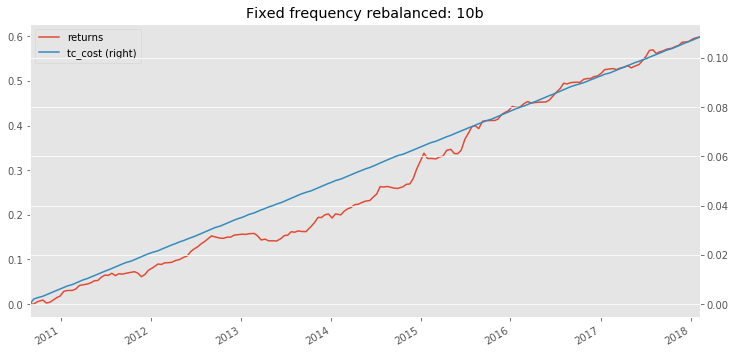

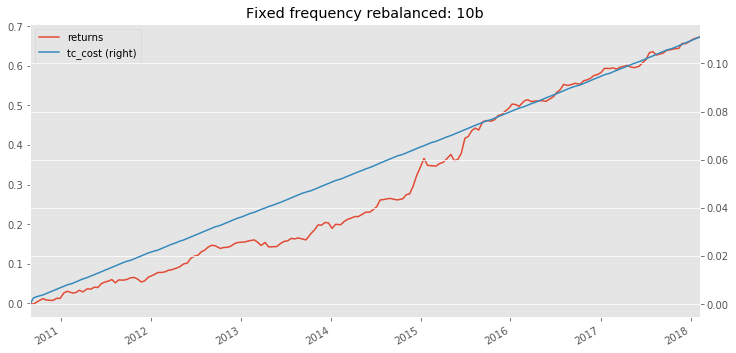

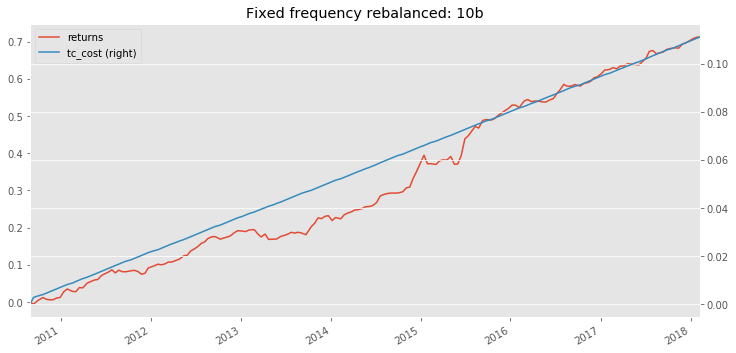

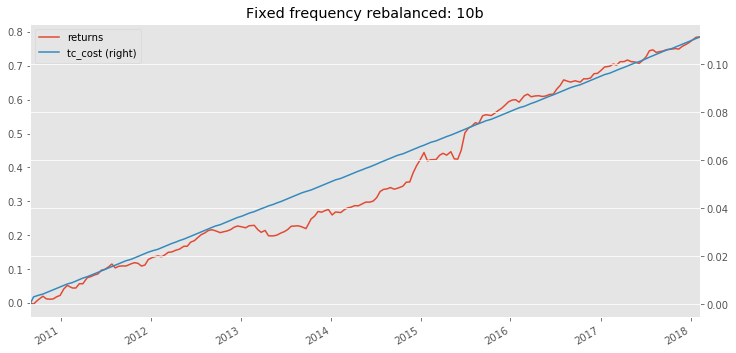

In [11]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')
industry_group = industry_data.groupby('trade_date')
constraint_risk = ['SIZE', 'LEVERAGE'] + industries_list
turn_over_target_base = 0.30
size_risk_lower = 0
size_risk_upper = 0
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
industry_lower = 1.
industry_upper = 1.

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[const_model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        benchmark_w = total_data.weight.values
        
        this_industry_data = industry_group.get_group(date)
        
        total_data = pd.merge(total_data, this_industry_data, on=['trade_date', 'code'])
        constraint_exp = total_data[constraint_risk].values
        industry = total_data.industry_name.values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
                
        values = total_data[const_model_features_keys].dropna()
        if values.empty:
            continue
        
        factor_values = factor_processing(total_data[const_model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = xgb_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, dates=ref_dates, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf2_{0}.csv'.format(int(s_i)))

## Lasso Regression
----------

In [12]:
"""
Training phase
"""

lasso_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
        model = LassoRegression(alpha=0.01, features=model_features_keys, fit_intercept=True) 
        model.fit(x, y)
        lasso_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-02-02 14:21:36,890 - ALPHA_MIND - INFO - trade_date: 2010-08-30 00:00:00 with 12758 obs training finished
2018-02-02 14:21:36,895 - ALPHA_MIND - INFO - trade_date: 2010-09-13 00:00:00 with 12759 obs training finished
2018-02-02 14:21:36,900 - ALPHA_MIND - INFO - trade_date: 2010-09-30 00:00:00 with 12760 obs training finished
2018-02-02 14:21:36,905 - ALPHA_MIND - INFO - trade_date: 2010-10-21 00:00:00 with 12760 obs training finished
2018-02-02 14:21:36,910 - ALPHA_MIND - INFO - trade_date: 2010-11-04 00:00:00 with 12761 obs training finished
2018-02-02 14:21:36,915 - ALPHA_MIND - INFO - trade_date: 2010-11-18 00:00:00 with 12762 obs training finished
2018-02-02 14:21:36,922 - ALPHA_MIND - INFO - trade_date: 2010-12-02 00:00:00 with 12762 obs training finished
2018-02-02 14:21:36,928 - ALPHA_MIND - INFO - trade_date: 2010-12-16 00:00:00 with 12762 obs training finished
2018-02-02 14:21:36,933 - ALPHA_MIND - INFO - trade_date: 2010-12-30 00:00:00 with 12762 obs training finished
2

2018-02-02 14:21:37,340 - ALPHA_MIND - INFO - trade_date: 2013-09-05 00:00:00 with 12782 obs training finished
2018-02-02 14:21:37,345 - ALPHA_MIND - INFO - trade_date: 2013-09-23 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,350 - ALPHA_MIND - INFO - trade_date: 2013-10-14 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,355 - ALPHA_MIND - INFO - trade_date: 2013-10-28 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,359 - ALPHA_MIND - INFO - trade_date: 2013-11-11 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,365 - ALPHA_MIND - INFO - trade_date: 2013-11-25 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,372 - ALPHA_MIND - INFO - trade_date: 2013-12-09 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,379 - ALPHA_MIND - INFO - trade_date: 2013-12-23 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,385 - ALPHA_MIND - INFO - trade_date: 2014-01-07 00:00:00 with 12783 obs training finished
2

2018-02-02 14:21:37,829 - ALPHA_MIND - INFO - trade_date: 2016-09-19 00:00:00 with 12770 obs training finished
2018-02-02 14:21:37,835 - ALPHA_MIND - INFO - trade_date: 2016-10-10 00:00:00 with 12771 obs training finished
2018-02-02 14:21:37,842 - ALPHA_MIND - INFO - trade_date: 2016-10-24 00:00:00 with 12773 obs training finished
2018-02-02 14:21:37,848 - ALPHA_MIND - INFO - trade_date: 2016-11-07 00:00:00 with 12775 obs training finished
2018-02-02 14:21:37,855 - ALPHA_MIND - INFO - trade_date: 2016-11-21 00:00:00 with 12778 obs training finished
2018-02-02 14:21:37,861 - ALPHA_MIND - INFO - trade_date: 2016-12-05 00:00:00 with 12781 obs training finished
2018-02-02 14:21:37,867 - ALPHA_MIND - INFO - trade_date: 2016-12-19 00:00:00 with 12783 obs training finished
2018-02-02 14:21:37,874 - ALPHA_MIND - INFO - trade_date: 2017-01-03 00:00:00 with 12785 obs training finished
2018-02-02 14:21:37,879 - ALPHA_MIND - INFO - trade_date: 2017-01-17 00:00:00 with 12785 obs training finished
2

2018-02-02 14:21:39,116 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.005 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-02-02 14:21:39,294 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:21:39,300 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:39,548 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:21:39,553 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:39,804 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:21:39,809 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:40,063 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:21:40,068 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:40,322 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:21:40,328 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:40,683 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:21:40,689 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:40,946 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:21:40,951 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:41,214 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:21:41,219 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:41,473 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:21:41,478 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:41,738 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:21:41,744 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:42,007 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:21:42,013 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:21:42,267 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:21:42,273 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:42,530 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:21:42,535 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:42,788 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:21:42,794 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:43,052 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:21:43,058 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:43,316 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:21:43,321 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:43,579 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:21:43,584 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:43,843 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:21:43,847 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:44,107 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:21:44,112 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:44,374 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:21:44,379 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:44,722 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:21:44,727 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:44,989 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:21:44,995 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:45,271 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:21:45,278 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:21:45,540 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:21:45,545 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:21:45,818 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:21:45,823 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:21:46,094 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:21:46,099 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:21:46,374 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:21:46,379 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:46,651 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:21:46,657 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:46,931 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:21:46,936 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:47,205 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:21:47,210 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:47,478 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:21:47,483 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:47,747 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:21:47,752 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:48,026 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:21:48,031 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:48,290 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:21:48,295 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:48,550 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:21:48,556 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:48,887 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:21:48,892 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:21:49,152 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:21:49,158 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:21:49,416 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:21:49,421 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:21:49,675 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:21:49,680 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:49,936 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:21:49,941 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:50,203 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:21:50,209 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:50,468 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:21:50,474 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:50,737 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:21:50,742 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:51,000 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:21:51,005 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:51,267 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:21:51,273 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:51,530 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:21:51,535 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:21:51,798 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:21:51,803 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:52,063 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:21:52,068 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:52,329 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:21:52,334 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:52,588 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:21:52,593 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:52,926 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:21:52,930 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:53,185 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:21:53,190 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:53,449 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:21:53,454 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:53,711 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:21:53,717 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:53,981 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:21:53,986 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:54,247 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:21:54,252 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:54,508 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:21:54,513 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:54,777 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:21:54,782 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:55,037 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:21:55,043 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:55,308 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:21:55,313 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:55,574 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:21:55,580 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:55,839 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:21:55,844 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:56,106 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:21:56,112 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:56,387 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:21:56,392 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:56,652 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:21:56,657 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:56,990 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:21:56,994 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:57,260 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:21:57,265 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:57,520 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:21:57,526 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:57,787 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:21:57,792 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:58,052 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:21:58,057 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:58,318 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:21:58,323 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:58,589 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:21:58,595 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:58,855 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:21:58,860 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:59,123 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:21:59,127 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:21:59,388 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:21:59,393 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:59,654 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:21:59,659 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:21:59,926 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:21:59,931 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:00,195 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:22:00,200 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:00,461 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:22:00,466 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:00,725 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:22:00,731 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:01,093 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:22:01,099 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:01,365 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:22:01,370 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:01,639 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:22:01,644 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:01,906 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:22:01,911 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:02,174 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:22:02,179 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:02,451 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:22:02,457 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:02,727 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:22:02,732 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:03,001 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:22:03,007 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:03,290 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:22:03,295 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:03,566 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:22:03,571 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:03,830 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:22:03,836 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:04,099 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:22:04,104 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:04,379 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:22:04,383 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:04,648 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:22:04,654 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:04,920 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:22:04,925 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:05,268 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:22:05,273 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:05,535 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:22:05,541 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:05,802 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:22:05,807 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:06,072 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:22:06,077 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:06,339 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:22:06,344 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:06,603 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:22:06,608 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:06,872 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:22:06,877 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:07,136 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:22:07,141 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:07,403 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:22:07,408 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:07,673 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:22:07,678 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:07,943 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:22:07,947 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:08,212 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:22:08,217 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:08,476 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:22:08,481 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:08,744 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:22:08,749 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:09,007 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:22:09,013 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:09,364 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:22:09,369 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:09,633 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:22:09,638 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:09,904 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:22:09,909 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:10,168 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:22:10,173 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:10,434 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:22:10,439 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:10,708 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:22:10,713 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:10,991 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:22:10,998 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:11,303 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:22:11,308 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:11,570 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:22:11,575 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:11,843 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:22:11,848 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:12,126 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:22:12,133 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:12,454 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:22:12,459 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:12,726 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:22:12,731 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:12,995 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:22:13,000 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:13,283 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:22:13,291 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:13,692 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:22:13,697 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:13,977 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:22:13,983 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:14,259 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:22:14,264 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:14,553 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:22:14,560 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:14,836 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:22:14,841 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:15,112 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:22:15,117 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:15,372 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:22:15,378 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:15,649 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:22:15,656 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:15,956 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:22:15,960 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:16,235 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:22:16,240 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:16,508 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:22:16,513 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:16,786 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:22:16,794 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:17,061 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:22:17,066 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:17,341 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:22:17,346 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:17,621 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:22:17,627 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:17,981 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:22:17,986 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:18,262 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:22:18,267 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:18,538 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:22:18,543 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:18,816 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:22:18,821 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:19,101 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:22:19,106 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:19,374 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:22:19,379 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:19,646 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:22:19,651 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:19,919 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:22:19,924 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:20,194 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:22:20,199 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:20,476 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:22:20,481 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:20,763 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:22:20,768 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:21,047 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:22:21,052 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:21,338 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:22:21,343 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:21,618 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:22:21,624 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:21,896 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:22:21,901 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:22,258 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:22:22,263 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:22,540 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:22:22,545 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:22,816 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:22:22,821 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:23,099 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:22:23,104 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:23,380 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:22:23,385 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:23,673 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:22:23,678 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:23,962 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:22:23,967 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:24,246 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:22:24,251 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:24,514 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:22:24,519 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:24,782 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:22:24,790 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:25,086 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:22:25,091 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:25,371 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:22:25,375 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:25,649 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:22:25,654 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:25,931 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:22:25,935 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:26,219 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:22:26,224 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:26,569 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:22:26,574 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:26,844 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:22:26,849 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:27,114 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:22:27,119 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:27,398 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:22:27,403 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:27,680 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:22:27,685 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:27,944 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:22:27,949 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:28,230 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:22:28,235 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:28,517 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:22:28,522 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:28,788 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:22:28,793 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:29,081 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:22:29,086 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:29,321 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-02 14:22:29,867 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-02-02 14:22:30,037 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:22:30,042 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:30,374 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:22:30,379 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:30,621 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:22:30,626 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:30,873 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:22:30,878 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:31,124 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:22:31,129 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:31,369 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:22:31,374 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:31,618 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:22:31,623 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:31,871 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:22:31,876 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:32,128 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:22:32,133 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:32,374 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:22:32,379 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:32,620 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:22:32,625 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:22:32,874 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:22:32,879 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:33,129 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:22:33,134 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:33,377 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:22:33,382 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:33,631 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:22:33,636 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:33,886 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:22:33,891 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:34,229 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:22:34,233 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:34,487 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:22:34,492 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:34,748 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:22:34,753 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:35,004 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:22:35,009 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:35,269 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:22:35,274 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:35,521 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:22:35,526 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:35,776 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:22:35,781 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:22:36,034 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:22:36,039 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:22:36,292 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:22:36,298 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:22:36,570 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:22:36,575 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:22:36,844 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:22:36,849 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:37,104 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:22:37,109 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:37,366 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:22:37,371 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:37,635 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:22:37,641 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:37,898 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:22:37,903 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:38,258 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:22:38,263 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:38,526 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:22:38,532 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:38,804 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:22:38,809 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:39,073 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:22:39,078 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:39,338 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:22:39,343 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:22:39,599 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:22:39,604 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:22:39,855 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:22:39,860 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:22:40,117 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:22:40,122 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:40,376 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:22:40,381 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:40,634 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:22:40,639 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:40,899 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:22:40,904 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:41,160 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:22:41,165 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:41,430 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:22:41,435 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:41,703 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:22:41,709 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:41,967 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:22:41,971 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:22:42,315 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:22:42,320 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:42,579 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:22:42,584 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:42,841 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:22:42,846 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:43,113 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:22:43,119 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:43,386 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:22:43,392 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:43,651 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:22:43,657 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:43,913 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:22:43,918 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:44,175 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:22:44,180 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:44,444 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:22:44,449 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:44,704 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:22:44,709 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:44,961 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:22:44,966 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:45,233 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:22:45,238 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:45,502 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:22:45,507 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:45,786 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:22:45,791 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:46,058 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:22:46,064 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:46,415 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:22:46,421 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:46,683 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:22:46,688 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:46,948 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:22:46,952 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:47,228 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:22:47,233 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:47,497 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:22:47,502 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:47,776 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:22:47,780 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:48,038 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:22:48,042 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:48,299 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:22:48,304 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:48,571 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:22:48,576 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:48,837 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:22:48,842 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:49,105 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:22:49,110 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:49,377 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:22:49,381 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:49,632 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:22:49,637 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:49,891 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:22:49,896 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:50,150 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:22:50,155 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:50,512 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:22:50,518 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:50,788 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:22:50,793 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:51,053 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:22:51,059 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:51,328 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:22:51,333 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:51,588 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:22:51,593 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:51,853 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:22:51,859 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:52,116 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:22:52,121 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:52,386 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:22:52,391 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:52,647 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:22:52,652 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:52,912 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:22:52,918 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:53,185 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:22:53,191 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:53,452 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:22:53,457 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:53,719 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:22:53,724 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:53,987 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:22:53,992 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:54,254 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:22:54,259 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:54,602 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:22:54,607 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:54,863 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:22:54,868 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:55,129 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:22:55,134 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:55,388 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:22:55,393 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:55,653 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:22:55,658 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:55,917 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:22:55,922 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:56,180 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:22:56,185 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:56,450 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:22:56,455 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:56,721 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:22:56,725 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:56,986 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:22:56,991 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:57,263 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:22:57,268 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:57,529 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:22:57,534 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:57,791 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:22:57,796 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:58,053 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:22:58,058 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:58,321 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:22:58,326 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:58,673 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:22:58,678 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:22:58,940 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:22:58,945 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:59,217 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:22:59,222 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:59,491 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:22:59,496 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:22:59,760 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:22:59,766 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:00,026 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:23:00,031 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:00,289 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:23:00,294 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:00,559 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:23:00,564 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:00,819 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:23:00,824 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:01,094 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:23:01,099 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:01,361 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:23:01,366 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:01,629 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:23:01,633 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:01,895 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:23:01,900 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:02,168 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:23:02,173 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:02,437 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:23:02,442 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:02,787 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:23:02,792 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:03,055 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:23:03,061 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:03,330 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:23:03,335 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:03,604 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:23:03,609 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:03,877 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:23:03,882 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:04,150 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:23:04,155 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:04,429 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:23:04,434 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:04,711 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:23:04,716 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:04,982 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:23:04,987 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:05,271 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:23:05,276 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:05,540 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:23:05,545 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:05,826 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:23:05,831 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:06,112 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:23:06,117 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:06,390 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:23:06,395 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:06,662 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:23:06,667 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:07,018 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:23:07,022 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:07,303 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:23:07,308 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:07,569 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:23:07,574 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:07,845 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:23:07,849 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:08,119 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:23:08,124 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:08,396 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:23:08,402 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:08,667 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:23:08,672 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:08,941 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:23:08,946 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:09,218 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:23:09,223 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:09,488 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:23:09,493 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:09,777 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:23:09,783 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:10,055 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:23:10,060 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:10,340 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:23:10,345 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:10,615 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:23:10,620 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:10,892 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:23:10,897 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:11,249 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:23:11,254 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:11,528 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:23:11,533 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:11,812 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:23:11,817 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:12,091 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:23:12,096 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:12,369 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:23:12,374 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:12,640 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:23:12,645 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:12,918 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:23:12,924 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:13,206 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:23:13,212 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:13,491 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:23:13,496 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:13,772 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:23:13,777 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:14,055 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:23:14,060 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:14,341 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:23:14,346 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:14,608 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:23:14,613 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:14,877 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:23:14,882 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:15,155 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:23:15,160 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:15,517 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:23:15,522 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:15,802 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:23:15,809 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:16,096 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:23:16,100 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:16,379 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:23:16,384 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:16,658 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:23:16,663 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:16,930 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:23:16,935 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:17,210 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:23:17,214 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:17,549 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:23:17,554 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:17,835 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:23:17,840 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:18,112 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:23:18,117 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:18,415 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:23:18,420 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:18,794 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:23:18,800 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:19,071 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:23:19,078 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:19,359 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:23:19,364 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:19,595 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-02 14:23:20,252 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-02-02 14:23:20,428 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:23:20,435 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:20,679 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:23:20,684 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:20,960 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:23:20,964 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:21,217 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:23:21,222 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:21,464 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:23:21,469 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:21,713 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:23:21,718 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:21,981 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:23:21,987 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:22,273 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:23:22,278 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:22,528 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:23:22,533 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:22,779 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:23:22,784 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:23,028 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:23:23,033 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:23:23,292 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:23:23,297 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:23,549 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:23:23,554 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:23,804 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:23:23,809 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:24,157 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:23:24,162 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:24,418 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:23:24,423 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:24,680 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:23:24,685 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:24,933 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:23:24,938 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:25,194 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:23:25,198 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:25,452 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:23:25,457 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:25,704 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:23:25,709 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:25,961 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:23:25,966 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:26,219 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:23:26,225 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:23:26,470 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:23:26,475 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:23:26,727 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:23:26,732 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:23:26,983 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:23:26,988 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:23:27,246 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:23:27,251 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:27,504 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:23:27,509 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:27,767 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:23:27,772 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:28,025 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:23:28,030 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:28,383 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:23:28,388 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:28,645 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:23:28,650 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:28,904 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:23:28,909 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:29,166 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:23:29,171 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:29,431 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:23:29,435 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:29,693 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:23:29,698 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:23:29,949 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:23:29,954 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:23:30,204 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:23:30,209 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:23:30,468 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:23:30,473 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:30,725 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:23:30,730 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:30,995 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:23:31,001 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:31,268 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:23:31,273 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:31,529 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:23:31,534 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:31,793 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:23:31,799 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:32,060 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:23:32,065 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:32,413 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:23:32,419 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:23:32,680 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:23:32,685 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:32,938 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:23:32,943 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:33,205 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:23:33,210 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:33,473 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:23:33,478 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:33,734 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:23:33,738 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:33,987 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:23:33,992 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:34,247 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:23:34,252 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:34,502 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:23:34,507 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:34,762 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:23:34,767 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:35,030 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:23:35,036 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:35,297 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:23:35,302 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:35,553 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:23:35,558 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:35,811 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:23:35,816 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:36,072 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:23:36,077 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:36,326 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:23:36,331 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:36,675 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:23:36,680 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:36,930 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:23:36,935 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:37,206 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:23:37,211 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:37,470 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:23:37,475 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:37,732 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:23:37,737 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:38,007 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:23:38,012 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:38,283 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:23:38,290 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:38,563 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:23:38,570 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:38,832 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:23:38,837 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:39,099 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:23:39,104 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:39,376 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:23:39,381 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:39,655 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:23:39,660 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:39,932 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:23:39,937 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:40,198 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:23:40,204 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:40,459 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:23:40,464 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:40,725 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:23:40,730 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:41,081 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:23:41,086 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:41,364 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:23:41,369 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:41,629 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:23:41,634 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:41,887 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:23:41,892 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:42,158 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:23:42,163 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:42,437 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:23:42,442 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:42,709 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:23:42,714 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:42,970 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:23:42,975 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:43,244 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:23:43,249 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:43,509 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:23:43,514 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:43,787 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:23:43,792 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:44,050 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:23:44,055 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:44,311 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:23:44,316 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:44,577 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:23:44,582 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:44,864 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:23:44,869 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:45,127 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:23:45,132 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:45,509 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:23:45,515 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:45,788 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:23:45,794 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:46,059 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:23:46,064 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:46,329 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:23:46,334 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:46,598 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:23:46,603 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:46,873 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:23:46,878 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:47,147 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:23:47,152 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:47,425 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:23:47,429 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:47,701 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:23:47,707 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:47,978 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:23:47,983 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:48,249 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:23:48,254 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:48,519 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:23:48,524 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:48,796 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:23:48,800 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:49,061 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:23:49,066 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:23:49,331 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:23:49,335 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:49,600 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:23:49,604 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:49,963 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:23:49,968 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:50,238 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:23:50,243 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:50,517 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:23:50,522 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:50,787 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:23:50,792 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:51,065 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:23:51,071 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:51,384 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:23:51,389 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:51,656 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:23:51,660 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:51,921 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:23:51,926 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:52,189 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:23:52,194 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:52,465 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:23:52,472 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:52,742 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:23:52,748 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:53,014 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:23:53,019 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:53,294 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:23:53,299 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:53,563 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:23:53,568 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:53,835 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:23:53,840 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:54,104 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:23:54,109 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:54,457 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:23:54,462 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:54,730 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:23:54,735 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:54,999 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:23:55,004 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:55,269 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:23:55,274 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:55,539 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:23:55,544 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:55,812 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:23:55,817 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:56,081 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:23:56,085 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:56,350 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:23:56,355 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:56,609 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:23:56,614 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:56,886 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:23:56,891 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:57,157 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:23:57,163 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:57,439 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:23:57,444 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:57,711 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:23:57,716 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:57,980 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:23:57,985 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:58,245 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:23:58,251 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:58,515 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:23:58,520 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:58,882 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:23:58,887 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:59,165 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:23:59,172 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:59,442 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:23:59,448 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:59,720 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:23:59,725 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:23:59,993 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:23:59,998 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:00,284 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:24:00,289 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:00,563 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:24:00,569 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:00,846 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:24:00,851 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:01,117 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:24:01,122 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:01,408 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:24:01,413 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:01,696 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:24:01,701 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:01,990 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:24:01,996 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:02,270 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:24:02,275 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:02,558 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:24:02,563 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:02,840 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:24:02,845 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:03,120 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:24:03,125 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:03,486 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:24:03,490 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:03,760 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:24:03,765 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:04,049 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:24:04,054 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:04,341 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:24:04,345 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:04,624 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:24:04,629 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:04,907 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:24:04,912 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:05,184 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:24:05,189 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:05,455 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:24:05,460 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:05,743 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:24:05,748 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:06,030 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:24:06,036 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:06,312 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:24:06,317 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:06,597 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:24:06,602 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:06,878 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:24:06,883 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:07,160 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:24:07,166 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:07,441 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:24:07,446 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:07,719 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:24:07,726 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:08,100 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:24:08,105 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:08,396 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:24:08,401 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:08,675 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:24:08,680 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:08,959 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:24:08,964 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:09,252 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:24:09,257 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:09,530 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:24:09,535 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:09,820 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:24:09,825 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:10,064 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-02 14:24:10,619 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-02-02 14:24:10,791 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-02 14:24:10,797 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:11,045 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-02 14:24:11,051 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:11,299 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-02 14:24:11,304 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:11,543 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-02 14:24:11,548 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:11,794 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-02 14:24:11,799 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:12,147 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-02 14:24:12,153 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:12,406 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-02 14:24:12,411 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:12,664 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-02 14:24:12,670 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:12,944 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-02 14:24:12,954 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:13,224 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-02 14:24:13,229 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:13,479 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-02 14:24:13,484 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:24:13,745 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-02 14:24:13,752 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:14,054 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-02 14:24:14,060 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:14,344 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-02 14:24:14,349 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:14,602 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-02 14:24:14,607 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:14,859 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-02 14:24:14,864 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:15,115 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-02 14:24:15,120 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:15,376 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-02 14:24:15,381 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:15,627 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-02 14:24:15,632 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:15,908 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-02 14:24:15,913 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:16,207 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-02 14:24:16,213 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:16,605 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-02 14:24:16,611 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:16,880 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-02 14:24:16,886 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:24:17,138 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-02 14:24:17,143 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:24:17,401 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-02 14:24:17,406 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:24:17,661 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-02 14:24:17,666 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:24:17,925 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-02 14:24:17,930 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:18,190 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-02 14:24:18,195 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:18,447 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-02 14:24:18,452 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:18,707 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-02 14:24:18,713 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:18,968 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-02 14:24:18,973 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:19,231 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-02 14:24:19,236 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:19,496 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-02 14:24:19,502 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:19,762 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-02 14:24:19,767 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:20,031 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-02 14:24:20,036 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:20,301 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-02 14:24:20,306 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:24:20,575 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-02 14:24:20,580 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-02 14:24:20,935 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-02 14:24:20,940 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-02 14:24:21,201 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-02 14:24:21,206 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:21,485 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-02 14:24:21,490 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:21,767 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-02 14:24:21,772 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:22,025 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-02 14:24:22,030 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:22,282 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-02 14:24:22,287 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:22,536 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-02 14:24:22,541 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:22,800 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-02 14:24:22,805 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:23,060 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-02 14:24:23,065 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-02 14:24:23,330 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-02 14:24:23,335 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:23,596 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-02 14:24:23,604 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:23,945 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-02 14:24:23,950 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:24,208 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-02 14:24:24,212 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:24,469 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-02 14:24:24,474 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:24,729 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-02 14:24:24,734 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:25,060 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-02 14:24:25,065 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:25,419 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-02 14:24:25,424 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:25,683 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-02 14:24:25,688 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:25,949 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-02 14:24:25,957 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:26,269 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-02 14:24:26,274 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:26,523 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-02 14:24:26,528 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:26,782 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-02 14:24:26,787 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:27,050 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-02 14:24:27,055 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:27,401 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-02 14:24:27,406 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:27,660 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-02 14:24:27,664 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:27,934 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-02 14:24:27,942 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:28,222 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-02 14:24:28,227 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:28,536 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-02 14:24:28,542 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:28,798 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-02 14:24:28,803 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:29,078 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-02 14:24:29,084 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:29,360 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-02 14:24:29,365 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:29,628 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-02 14:24:29,633 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:29,995 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-02 14:24:30,001 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:30,292 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-02 14:24:30,297 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:30,557 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-02 14:24:30,562 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:30,824 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-02 14:24:30,829 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:31,084 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-02 14:24:31,089 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:31,351 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-02 14:24:31,356 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:31,618 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-02 14:24:31,623 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:31,882 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-02 14:24:31,887 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:32,151 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-02 14:24:32,156 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:32,417 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-02 14:24:32,422 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:32,682 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-02 14:24:32,687 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:32,965 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-02 14:24:32,974 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:33,247 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-02 14:24:33,252 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:33,515 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-02 14:24:33,520 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:33,779 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-02 14:24:33,785 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:34,082 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-02 14:24:34,087 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:34,476 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-02 14:24:34,482 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:34,760 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-02 14:24:34,766 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:35,065 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-02 14:24:35,072 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:35,374 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-02 14:24:35,379 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:35,651 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-02 14:24:35,656 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:35,919 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-02 14:24:35,925 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:36,186 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-02 14:24:36,192 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:36,460 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-02 14:24:36,464 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:36,723 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-02 14:24:36,728 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:36,987 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-02 14:24:36,991 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:37,264 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-02 14:24:37,273 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:37,539 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-02 14:24:37,544 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:37,809 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-02 14:24:37,814 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:38,106 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-02 14:24:38,111 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:38,380 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-02 14:24:38,387 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:38,667 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-02 14:24:38,671 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:39,025 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-02 14:24:39,030 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:39,329 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-02 14:24:39,334 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:39,601 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-02 14:24:39,608 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:39,882 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-02 14:24:39,889 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:40,174 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-02 14:24:40,179 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:40,454 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-02 14:24:40,459 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:40,733 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-02 14:24:40,738 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:40,998 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-02 14:24:41,003 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:41,289 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-02 14:24:41,293 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:41,556 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-02 14:24:41,561 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:41,837 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-02 14:24:41,842 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:42,106 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-02 14:24:42,111 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:42,388 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-02 14:24:42,393 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:42,689 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-02 14:24:42,694 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:42,976 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-02 14:24:42,982 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:43,265 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-02 14:24:43,272 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:43,663 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-02 14:24:43,670 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:43,942 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-02 14:24:43,947 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:44,243 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-02 14:24:44,248 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:44,536 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-02 14:24:44,542 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:44,833 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-02 14:24:44,839 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:45,117 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-02 14:24:45,122 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:45,430 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-02 14:24:45,435 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:45,751 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-02 14:24:45,758 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:46,138 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-02 14:24:46,143 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:46,439 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-02 14:24:46,444 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:46,731 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-02 14:24:46,736 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:47,007 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-02 14:24:47,012 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:47,285 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-02 14:24:47,290 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:47,573 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-02 14:24:47,578 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:47,856 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-02 14:24:47,861 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:48,132 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-02 14:24:48,137 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:48,534 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-02 14:24:48,542 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:48,821 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-02 14:24:48,827 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:49,122 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-02 14:24:49,128 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:49,439 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-02 14:24:49,444 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:49,750 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-02 14:24:49,757 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:50,052 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-02 14:24:50,057 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:50,352 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-02 14:24:50,357 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:50,679 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-02 14:24:50,687 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:50,984 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-02 14:24:50,990 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:51,295 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-02 14:24:51,302 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:51,613 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-02 14:24:51,622 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:51,920 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-02 14:24:51,924 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:52,209 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-02 14:24:52,215 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:52,503 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-02 14:24:52,508 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:52,811 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-02 14:24:52,819 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:53,126 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-02 14:24:53,133 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:53,578 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-02 14:24:53,586 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:53,889 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-02 14:24:53,894 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:54,176 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-02 14:24:54,182 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:54,463 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-02 14:24:54,468 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:54,762 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-02 14:24:54,768 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:55,061 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-02 14:24:55,066 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:55,386 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-02 14:24:55,392 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:55,678 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-02 14:24:55,686 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-02 14:24:55,990 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-02 14:24:55,996 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:56,276 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-02 14:24:56,282 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:56,602 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-02 14:24:56,607 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:56,885 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-02 14:24:56,890 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:57,175 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-02 14:24:57,180 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:57,470 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-02 14:24:57,476 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:57,778 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-02 14:24:57,784 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:58,081 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-02 14:24:58,086 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:58,513 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-02 14:24:58,519 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:58,796 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-02 14:24:58,801 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:59,118 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-02 14:24:59,125 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:59,426 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-02 14:24:59,433 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:24:59,743 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-02 14:24:59,750 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:00,076 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-02 14:25:00,082 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:00,397 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-02 14:25:00,405 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:00,707 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-02 14:25:00,712 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:01,015 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-02 14:25:01,022 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:01,332 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-02 14:25:01,337 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:01,633 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-02 14:25:01,638 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:01,919 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-02 14:25:01,924 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:02,208 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-02 14:25:02,213 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:02,483 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-02 14:25:02,488 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:02,782 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-02 14:25:02,787 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-02 14:25:03,022 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished


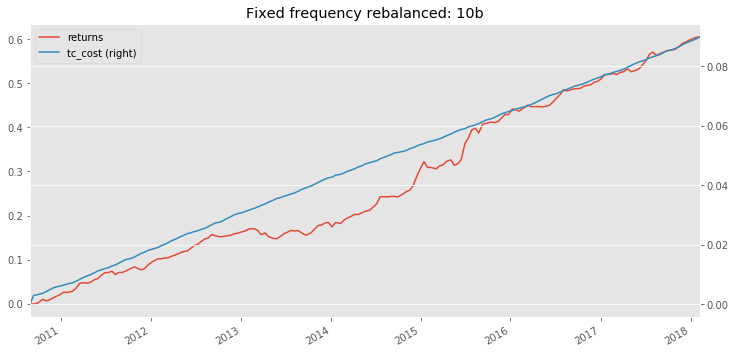

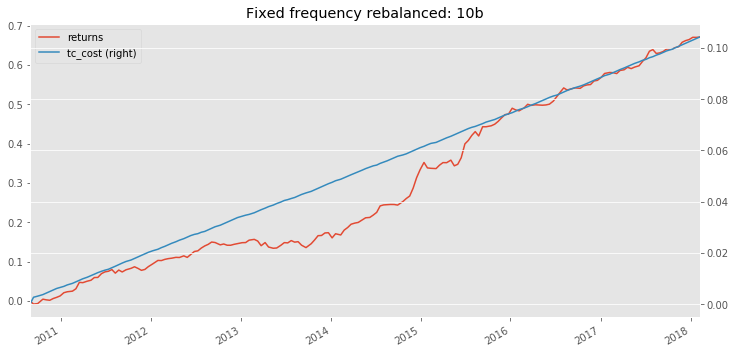

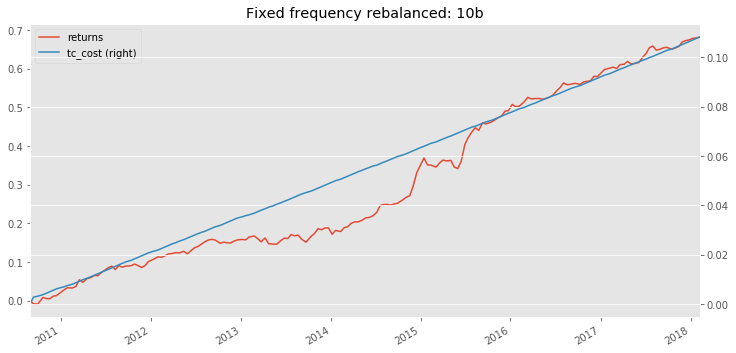

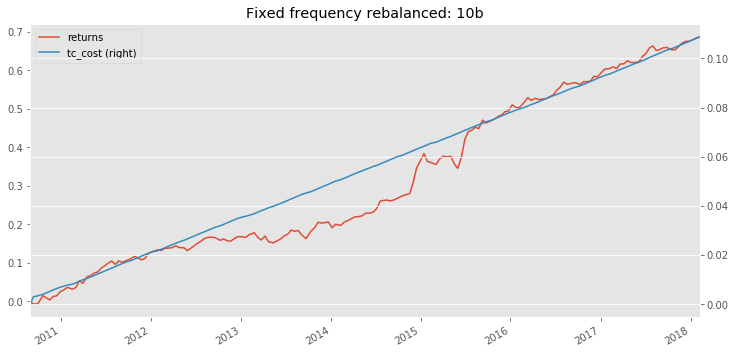

In [13]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[const_model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values
        
        this_industry_data = industry_group.get_group(date)
        
        total_data = pd.merge(total_data, this_industry_data, on=['trade_date', 'code'])
        constraint_exp = total_data[constraint_risk].values
        industry = total_data.industry_name.values

        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
        
        factor_values = factor_processing(total_data[const_model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = lasso_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, dates=ref_dates, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf_{0}.csv'.format(int(s_i)))